## Credit Card
#### Approach :

#### Steps Involved : 
#### Step-1. Data Processing and Feature Creation
(1_Data_Load_Feature_Creation_Processing_New.ipynb)
#### Step-2. Profit Calculation : Train Entries
(2_Train_Profit_Calculation.ipynb)
#### Step-3. First Set of Classifier Model : Shortlisting Potential customers by Classifier model   
(3a_i_XGBClass_Grid_LogLoss_PropensityModel_Approach.ipynb)
#### Step-4. Feature Elimination : Retraining Models - Final Classifier Model 
(3a_ii_Feature_Elimination_XGB.ipynb)
#### Step-5. Probability Threshold : Calculating for the Train dataset customers from Step-4
(3a_iii_ProbabCutOff_Approach.ipynb)
#### Step-6. Regression model trained on ONLY all those customers without Default (Target/Default = 0)
(3a_iv_XGBReg_RMSE_Approach.ipynb)
#### Step-7. (Part-a) Scoring on Test data using Step-1 Classifier Model and using the Probability Threshold calculated in Step-5 to further shortlist highly potential customers
#### Step-7. (Part-b) Scoring on Step-7a customers using Step-6 Regression Model and predicting the amount of Profit the highly potential customers will bring
(4_Scoring_Approach.ipynb)

* Classifier Model has been built using the XGBoost library, along with Grid Search and 3 different sets of models are prepared, which are further compared on the basis of LogLoss value on validation dataset. On Checking the Lift, LogLoss, AUC metrics, further feature elimination has been done and another category of 3 set of models have been built, and the best model is selected on the basis of Lift provided in first decile, assuming no leakage introduced.

* To ensure the generalization being introduced by the model, the Train dataset has been split into 2 parts (80% and 20%) :
* a) 1st model is trained on the 80% dataset and validated on 20% dataset 
* b) The best selected hyper-parameters are further used for model trained on the 100% Train dataset and results in the final model of Approach
* c) Depending upon the best possible probability threshold, a CutOff has been found 
* d) Recursive feature elimination has been done, followed by model building at each stage
* e) Best model from above step is selected without taking the features which are introducing leakages
* The final model from above step is used to score on the Test dataset, and further Probability Threshold has been calculated using it

* All the entries from the Train Dataset are taken along with their Target Profit > 0
* Regression Model has been built using the XGBoost library and with 3 different set of hyper-parameters

##### Other considerations:
* The target variable with the binary value of 0 and 1 for the persons with Default or without Default has been taken into account in Step-3 for shortlisting of the customers. The variable with the actual Profit has been calculated in Step-2 and used later in Step-6 for the regression model purpose.

## FINAL RESULT :  
### No. of customers shortlised : 4992 
### File Name :  'cc_approach_Final_Predictions.csv'

In [39]:
# Change values in cells with '+++++++ INPUT : ' as per need! Not valid for all cells, Paths are MUST!
import platform
print(platform.python_version())

2.7.12


In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
import random

import sklearn
from sklearn.cross_validation import train_test_split
from sklearn.externals import joblib
from xgboost.sklearn import XGBRegressor

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ++++++++ INPUT : Change These variables, as per your need +++++++
model_path='/home/pgoyal/Projects/nb/model/'
home_path='/home/pgoyal/Projects/nb/'

# Make sure the train_file has columns with names (Target, ID_Col)
train_file = 'train_final.csv'
train_profit_file = "train_profits.csv"

In [3]:
# ++++++++ INPUT : Change These variables, as per your need +++++++
# Models Name:
model1 = 'xgb1_cc_rmse_app2.pkl'
model2 = 'xgb2_cc_rmse_app2.pkl'
model2b = 'xgb2b_cc_rmse_app2.pkl'
model3 = 'xgb3_cc_rmse_app2.pkl'

In [4]:
# modelfit(..) and Grid Search Parameters
# Introduce 'switch' statements here, and then select these variables accordingly
modelfit_metric='rmse'

In [5]:
def RMSE(y_true,y_pred):
    import numpy as np
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

#scoring_parameter='mean_squared_error'

In [6]:
scoring_objective='reg:linear'
scoring_nthread=4
scoring_seed=45

In [7]:
train_data = pd.read_csv(home_path+train_file, sep=',')
train_profit = pd.read_csv(home_path+train_profit_file, sep=',')

In [8]:
train_data.Target.value_counts()

0    50456
1     9510
Name: Target, dtype: int64

In [9]:
train_profit.rename(columns={ train_profit.columns[0]: 'ID_Col'}, inplace=True)
train_profit.columns

Index([u'ID_Col', u'entry_prof_inf'], dtype='object')

In [10]:
print(train_data.shape)
print(train_profit.shape)

(59966, 41)
(59966, 2)


In [11]:
train_final = pd.merge(train_data, train_profit, how='inner', left_on='ID_Col', right_on='ID_Col', left_index=False, 
                      right_index=False,)
train_final.shape

(59966, 42)

In [12]:
train_final.columns

Index([u'ID_Col', u'score_3', u'score_4', u'score_5', u'score_6', u'risk_rate',
       u'amount_borrowed', u'borrowed_in_months', u'income', u'n_bankruptcies',
       u'n_defaulted_loans', u'n_accounts', u'facebook_profile',
       u'score_1_mapped_score_1_0', u'score_1_mapped_score_1_1',
       u'score_1_mapped_score_1_2', u'score_1_mapped_score_1_3',
       u'score_1_mapped_score_1_4', u'score_1_mapped_score_1_others',
       u'real_state_mapped_real_state_0', u'real_state_mapped_real_state_1',
       u'real_state_mapped_real_state_2',
       u'real_state_mapped_real_state_others', u'gender_f',
       u'score_2_mapped_score_2_0', u'score_2_mapped_score_2_1',
       u'score_2_mapped_score_2_2', u'score_2_mapped_score_2_3',
       u'score_2_mapped_score_2_4', u'score_2_mapped_score_2_5',
       u'score_2_mapped_score_2_6', u'score_2_mapped_score_2_others',
       u'state_mapped_state_0', u'state_mapped_state_1',
       u'state_mapped_state_2', u'state_mapped_state_3',
       u'state_ma

In [13]:
# Selecting only the Instances which have not done the Default, i.e., Target =0 , and using these only to build the model
train_final = train_final[train_final.Target==0]

### Removing the Date Variables : As per learning from the Classification Model

In [14]:
date_vars = ['last_payment_end_last_loan', 'last_payment_diff', 'end_last_loan_diff']
train_final.drop(date_vars, axis=1, inplace=True)

In [15]:
train_final.shape

(50456, 39)

In [16]:
val_tar = train_final["entry_prof_inf"]
train_final.drop(['ID_Col','Target','entry_prof_inf'], axis=1, inplace=True)

In [17]:
print train_final.shape

(50456, 36)


In [18]:
val_tar = pd.DataFrame(pd.Series(val_tar))

In [19]:
# Separate into Train and Validation
random.seed(45)
X_train, X_val, Y_train, Y_val = sklearn.cross_validation.train_test_split(train_final, val_tar, 
                                                                           test_size = 0.2, random_state = 5)

In [20]:
# xgboost fn
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=Y_train[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=[ modelfit_metric ], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(Y_train),eval_metric=modelfit_metric)     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
     
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [21]:
predictors  = list(X_train.columns)

#### Model-1

Will train until cv error hasn't decreased in 50 rounds.


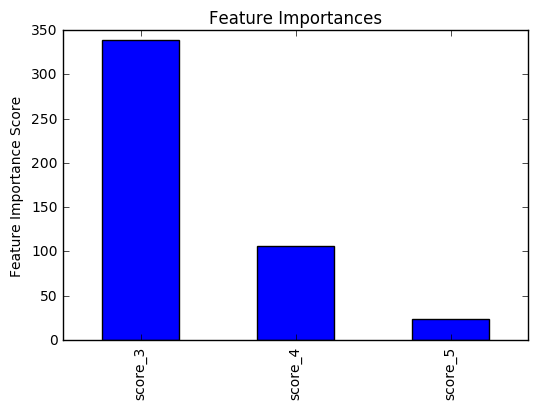

In [22]:
# xgboost classifier : Using the best params from Model-1 from Approach-1
xgb1 = XGBRegressor(max_depth= 4, min_child_weight= 1,gamma=0.2, colsample_bytree=0.8, subsample=0.7, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, n_estimators=700,
                     objective=scoring_objective, nthread=scoring_nthread, seed=scoring_seed)

modelfit(xgb1, X_train, predictors)

In [23]:
# Save the model
joblib.dump(xgb1, model_path+model1)
# Train 
from sklearn.metrics import mean_squared_error
y_predS = xgb1.predict(X_train)
print('Train RMSE of Model 1 : ' + str(RMSE(Y_train, y_predS)))
# Validation MSE
val_pred = xgb1.predict(X_val)
rmse_1 = RMSE(Y_val, val_pred)
print('Validation RMSE of Model 1 : ' + str(rmse_1))

Train RMSE of Model 1 : 7278.96633548
Validation RMSE of Model 1 : 7430.98430033


#### Model-2

Will train until cv error hasn't decreased in 50 rounds.


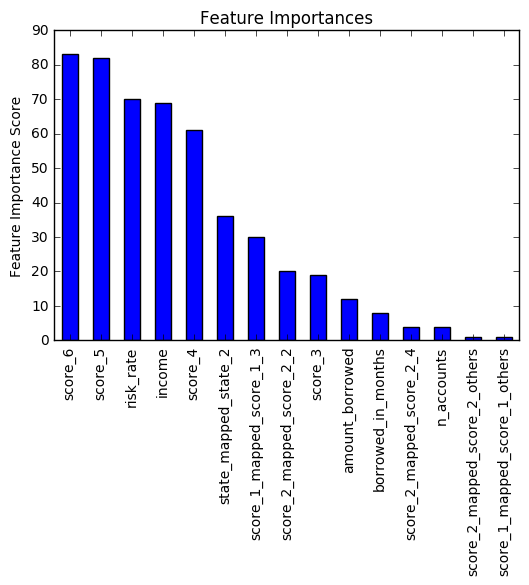

In [24]:
# xgboost classifier : Using the best params from Model-1 from Approach-1
xgb2 = XGBRegressor(max_depth= 1, min_child_weight= 2,gamma=0.0, colsample_bytree=0.6, subsample=0.9, reg_alpha = 1, 
                     reg_lambda = 5, max_delta_step = 0, scale_pos_weight= 1, learning_rate = 0.01, n_estimators=500,
                     objective=scoring_objective, nthread=scoring_nthread, seed=scoring_seed)

modelfit(xgb2, X_train, predictors)

In [25]:
# Save the model# Model with prcnt_common feature
joblib.dump(xgb2, model_path+model2)
# Train 
y_predS_xgb2 = xgb2.predict(X_train)
print('Train RMSE : ' + str(RMSE(Y_train, y_predS_xgb2)))
# Validation
val_pred_xgb2 = xgb2.predict(X_val)
rmse_2 = RMSE(Y_val, val_pred_xgb2)
print('Validation RMSE of Model 2 : ' + str(rmse_2))

Train RMSE : 4837.89435969
Validation RMSE of Model 2 : 4954.30667526


#### Model-2b

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[484] cv-mean:4842.297754	cv-std:36.9225019719


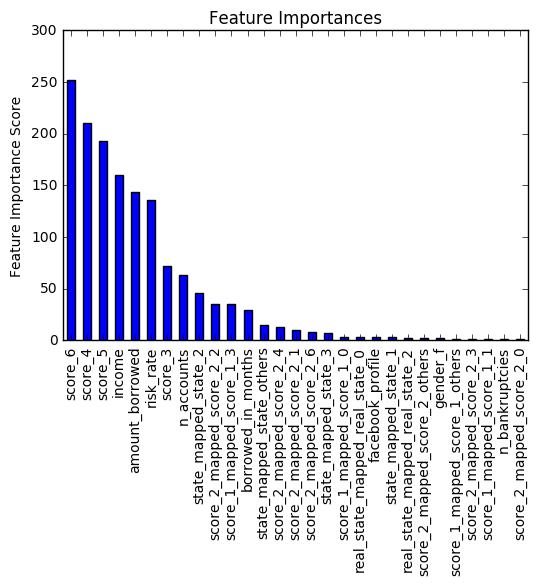

In [26]:
# xgboost classifier : Using the best params from Model-1 from Approach-1
xgb2b = XGBRegressor(max_depth= 2, min_child_weight= 3,gamma=0.0, colsample_bytree=0.7, subsample=0.9, reg_alpha = 1, 
                     reg_lambda = 5, max_delta_step = 0, scale_pos_weight= 1, learning_rate = 0.01, n_estimators=600,
                     objective=scoring_objective, nthread=scoring_nthread, seed=scoring_seed)

modelfit(xgb2b, X_train, predictors)

In [27]:
# Save the model# Model with prcnt_common feature
joblib.dump(xgb2b, model_path+model2b)
# Train 
y_predS_xgb2b = xgb2b.predict(X_train)
print('Train RMSE : ' + str(RMSE(Y_train, y_predS_xgb2b)))
# Validation
val_pred_xgb2b = xgb2b.predict(X_val)
rmse_3 = RMSE(Y_val, val_pred_xgb2b)
print('Validation RMSE of Model 3 : ' + str(rmse_3))

Train RMSE : 4831.36129015
Validation RMSE of Model 3 : 4955.2921152


### Selecting the Best Model from the above set of 3 Models (xgb1, xgb2,  xgb2b) and training it on the full Train dataset

In [28]:
print('Validation RMSE of Model 1 : ' + str(rmse_1))
print('Validation RMSE of Model 2 : ' + str(rmse_2))
print('Validation RMSE of Model 3 : ' + str(rmse_3))

Validation RMSE of Model 1 : 7430.98430033
Validation RMSE of Model 2 : 4954.30667526
Validation RMSE of Model 3 : 4955.2921152


In [29]:
print " Out of the above 3 models, the Model -", np.argmin([rmse_1, rmse_2, rmse_3])+1 , " has least RMSE, so selecting it"

 Out of the above 3 models, the Model - 2  has least RMSE, so selecting it


In [30]:
# Checking the mean of the profit values, wrt profit
val_tar.mean()

entry_prof_inf    5562.469616
dtype: float64

In [31]:
# ++++++++ INPUT : ENter the model name +++++++
model_sel = xgb2

#### Feature Importance

In [32]:
feat_imp = pd.Series(model_sel.booster().get_fscore()).sort_values(ascending=False)
feat_imp =pd.DataFrame({'features': feat_imp.index, 'importance' : feat_imp.values})
feat_imp['importance_percent']  = feat_imp['importance']/feat_imp['importance'].sum()

In [33]:
feat_imp.iloc[0:21]

,features,importance,importance_percent
0,score_6,83,0.166
1,score_5,82,0.164
2,risk_rate,70,0.140
3,income,69,0.138
4,score_4,61,0.122
5,state_mapped_state_2,36,0.072
6,score_1_mapped_score_1_3,30,0.060
7,score_2_mapped_score_2_2,20,0.040
8,score_3,19,0.038
9,amount_borrowed,12,0.024


In [34]:
def draw_feature_importance(fea_imp_df, nb, imp_col):
    fea_imp_df = fea_imp_df.sort_values(imp_col).reset_index(drop=True)
    fea_imp_df = fea_imp_df[-1*nb:].reset_index(drop=True)

    plt.figure(figsize=(10, nb*0.3))
    plt.title("Top %d Most Important Features"%nb)
    plt.barh(fea_imp_df.index, fea_imp_df[imp_col], color='#348ABD', align="center", lw='2', edgecolor='#348ABD', alpha=0.6)
    plt.yticks(fea_imp_df.index, fea_imp_df['features'], fontsize=12,)
    plt.ylim([-1, nb])
    plt.xlim([0, fea_imp_df[imp_col].max()*1.1])
    plt.show()

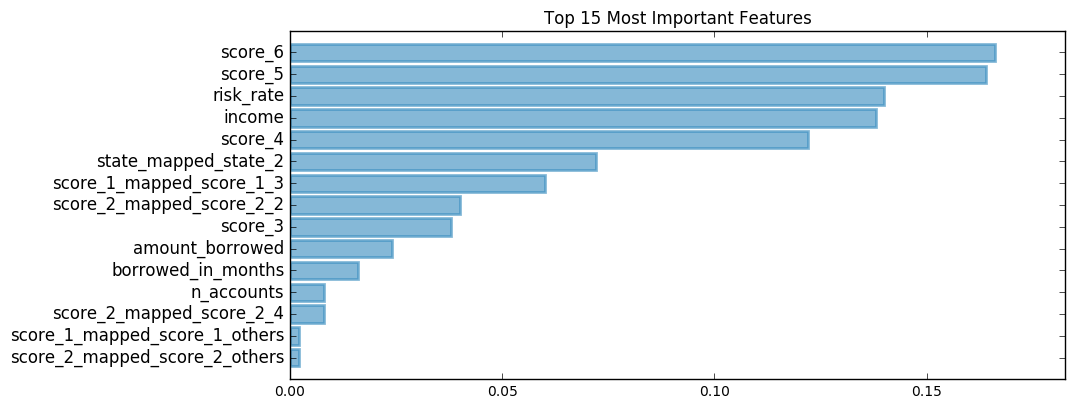

In [35]:
draw_feature_importance(feat_imp, feat_imp.shape[0], 'importance_percent')

In [36]:
# xgboost fn
def modelfit2(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=val_tar[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=[modelfit_metric], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(val_tar),eval_metric=modelfit_metric)     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Will train until cv error hasn't decreased in 50 rounds.


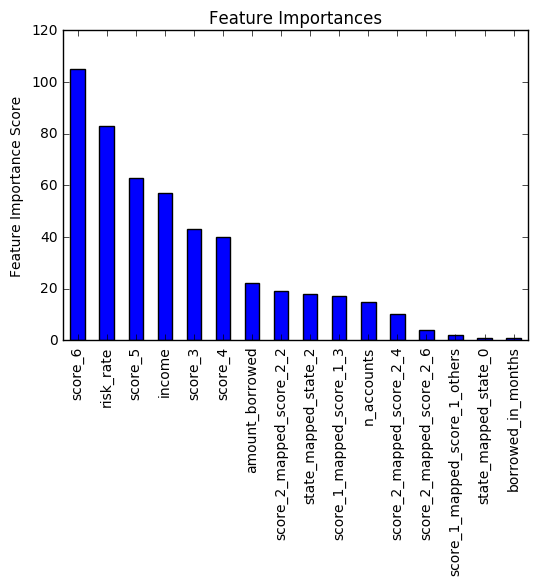

In [37]:
# Using the final selected model on the initial given full training dataset
xgb3 = XGBRegressor(max_depth= 1, min_child_weight= 2,gamma=0.0, colsample_bytree=0.6, subsample=0.9, reg_alpha = 1, 
                     reg_lambda = 5, max_delta_step = 0, scale_pos_weight= 1, learning_rate = 0.01, n_estimators=500,
                     objective=scoring_objective, nthread=scoring_nthread, seed=scoring_seed)
modelfit2(xgb3, train_final, predictors)

In [38]:
# Selecting the FINAL MODEL as the one trained with INITIAL grid and trained on the Full Train dataset
joblib.dump(xgb3, model_path+model3)
# Train 
y_predS_final = xgb3.predict(train_final)
rmse_final = RMSE(val_tar[[0]].values, y_predS_final)
print('Train RMSE on Final Model : ' + str(rmse_final))

Train RMSE on Final Model : 4861.12126361


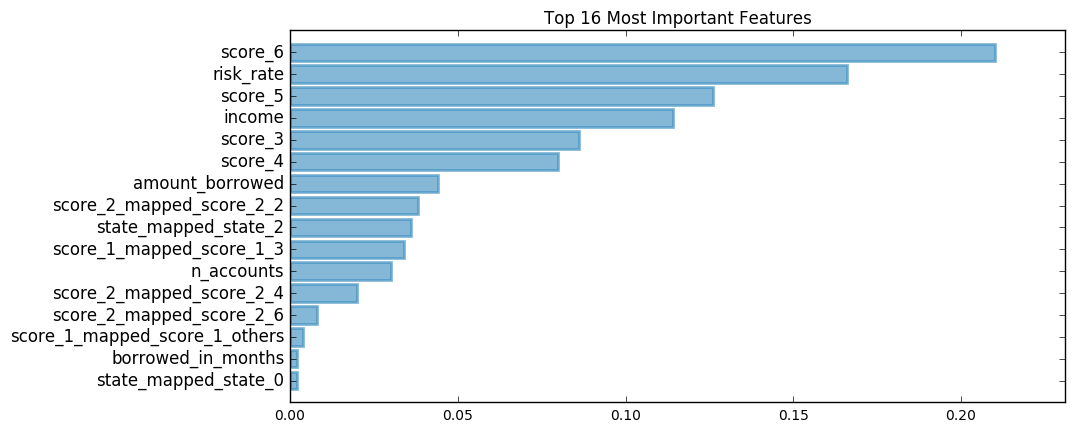

In [40]:
feat_imp = pd.Series(xgb3.booster().get_fscore()).sort_values(ascending=False)
feat_imp =pd.DataFrame({'features': feat_imp.index, 'importance' : feat_imp.values})
feat_imp['importance_percent']  = feat_imp['importance']/feat_imp['importance'].sum()
draw_feature_importance(feat_imp, feat_imp.shape[0], 'importance_percent')

In [ ]:
from alibi.explainers import ALE

def compute_and_plot_ale(model, X, feature_names, top_features_df):

    # Filter to top 20 features by importance
    top_features = top_features_df['Feature'].tolist()

    # Define a prediction function
    def predict_fn(X):
        return model.predict(X)

    # Initialize ALE explainer
    ale_explainer = ALE(predict_fn, feature_names=feature_names)

    # Compute ALE explanations
    ale_exp = ale_explainer.explain(X.values)

    # Plot ALE for the top 20 features
    for feature_name in top_features:
        feature_index = feature_names.index(feature_name)
       
        # Get ALE values and feature values for the selected feature
        ale_feature = ale_exp.ale_values[feature_index]
        ale_feature_centers = ale_exp.feature_values[feature_index]
       
        # Plot the ALE graph
        plt.figure(figsize=(8, 6))
        plt.plot(ale_feature_centers, ale_feature, marker='o', linestyle='-', color='skyblue')
        plt.xlabel(feature_name)
        plt.ylabel('ALE')
        plt.title(f'ALE for Feature: {feature_name}')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example Usage:
# Assume `best_model` is your trained model and `X_train` is your training dataset
# top_20_importance_df contains the column 'Feature' for feature names
compute_and_plot_ale(best_model, X_train, X_train.columns.tolist(), top_20_importance_df)
